$$ \Large \underline
{\textbf{Propagación de Fisuras}}
$$

Determine la deformación y los esfuerzos principales en función de la posición para una chapa con
un agujero en el centro sujeta a tracción por sus extremos, como se muestra en la figura. Las
dimensiones de la chapa son de $20\ x\ 10\ pulgadas$ y su espesor de $1\ pulgada$. El radio del agujero
central es también de $1\ pulgada$. Tome $E = 30 x 10^{6}\
 psi$ y $n = 0.30$.



Analice el problema con número creciente de elementos y estudie su convergencia.

<center><img src="ImgProb02G03.png"></center>

In [1]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt
import MEF as mef

In [2]:
lc = 2
h = 10  # in
b = 20  # in
v = 0.3  # coef Poisson
Ei = 30e6  # psi para acero 
r = 1  # in  radio del agujero
t = 1  # in  espesor de la chapa
T = 1000

In [3]:
gmsh.initialize()

Info    : Increasing process stack size (8192 kB < 16 MB)


In [4]:
gmsh.model.add('Chapa_agujero_central')

In [5]:
pc = gmsh.model.geo.addPoint(0,0,0,lc)
p1 = gmsh.model.geo.addPoint(r,0,0,lc/15)
p2 = gmsh.model.geo.addPoint(b/2,0,0,lc)
p3 = gmsh.model.geo.addPoint(b/2,h/2,0,lc)
p4 = gmsh.model.geo.addPoint(0,h/2,0,lc)
p5 = gmsh.model.geo.addPoint(0,r,0,lc/15)

In [6]:
l1 = gmsh.model.geo.addLine(p1,p2)
l2 = gmsh.model.geo.addLine(p2,p3)
l3 = gmsh.model.geo.addLine(p3,p4)
l4 = gmsh.model.geo.addLine(p4,p5)
c1 = gmsh.model.geo.addCircleArc(p5, pc, p1)

In [7]:
C1 = gmsh.model.geo.addCurveLoop([l1,l2,l3,l4,c1])

In [8]:
S1 = gmsh.model.geo.addPlaneSurface([C1])

In [9]:
gmsh.model.geo.synchronize()

La linea vertical de la izquierda no se movera en la dirección x por simetria, ya que se aplica la misma tension de ambos lados. 

La linea horizontal de aba no se movera en la dirección y, también por simetria. 

In [10]:
Empotrado_x = gmsh.model.addPhysicalGroup(1, [l4])
gmsh.model.setPhysicalName(1,Empotrado_x,'Empotrado en x')
Empotrado_y = gmsh.model.addPhysicalGroup(1, [l1])
gmsh.model.setPhysicalName(1,Empotrado_y,'Empotrado en y')

Traccionado = gmsh.model.addPhysicalGroup(1,[l2])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie,'Superficie')

In [11]:
gmsh.model.mesh.generate(2)
gmsh.model.geo.synchronize()
# gmsh.fltk.run() estoy en remoto

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Circle)
Info    : Done meshing 1D (Wall 0.00277399s, CPU 0.003208s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00217164s, CPU 0.001719s)
Info    : 125 nodes 252 elements


In [12]:
NodeInfo = gmsh.model.mesh.get_nodes()
Nn = NodeInfo[0].shape[0]
ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)   # ETAGS = numeracion de cada elemento
                                                            # ELEMENTS = ravel de los nodos que posee cada elemento
MN = NodeInfo[1].reshape(Nn,3)  # matriz coordenadas de los nodos
MN = np.append(MN[1:,:],[np.zeros(3)],0)  # llevo la primer fila al final porque nombra al nodo del centro como el último taggeado
MC = ELEMENTS.reshape(ETAGS.shape[0],3)  # matriz conectividad

In [13]:
Ne, Nnxe = MC.shape

In [14]:
E = np.zeros(Ne)
for e in range(Ne):
    E[e] = Ei

In [15]:
MC = MC - np.ones([Ne,Nnxe])  # resto 1 para acomodar a lenguaje python

In [16]:
gmsh.option.setNumber("Mesh.MshFileVersion",2.2)
gmsh.write('chapa_agujero.msh')

Info    : Writing 'chapa_agujero.msh'...
Info    : Done writing 'chapa_agujero.msh'


In [17]:
glxn = 2
dimension_elementos = 2

In [18]:
K, Ke, D, B = mef.Kglobal_barra(MN, MC, E, glxn, dimension_elementos, v,t) 

In [19]:
nodos_empot_x, xyz_empot_x = gmsh.model.mesh.getNodesForPhysicalGroup(1, Empotrado_x)
nodos_empot_y, xyz_empot_y = gmsh.model.mesh.getNodesForPhysicalGroup(1, Empotrado_y)

nodos_empot_x = el número del nodo que se encuentra empotrado en x ; xyz_empot_x = ravel de las coordenadas de cada nodo empotrado en x

nodos_empot_y = el número del nodo que se encuentra empotrado en y ; xyz_empot_y = ravel de las coordenadas de cada nodo empotrado en y

In [20]:
s = []  # el vector s indica la direccion de que nodo sabemos cuanto se desplaza.
        # en este caso se asignan los valores de las direcciones de cada nodo empotrado
for n in nodos_empot_x-1:
    s.append(glxn*n)
for n in nodos_empot_y-1:
    s.append(glxn*n+1)

s.append((NodeInfo[0][0]-1)*glxn)
s.append((NodeInfo[0][0]-1)*glxn+1)

s = np.array(s).astype(int)

Us = np.zeros([s.shape[0]]).reshape([-1,1])

In [21]:
r = mef.vector_complemento(s, MN, glxn).astype(int)

In [22]:
entityTraccionada = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado)
Tgroup, Ttraccionada, Ltraccionada = gmsh.model.mesh.getElements(1, entityTraccionada[0])
Nlineastraccionadas = len(Ttraccionada[0])
MCtraccionadas = Ltraccionada[0].reshape(Nlineastraccionadas,2)-1

In [23]:
Fr = np.zeros_like(r)  # Vector fuerzas en los nodos que empotrados
for e in range(Nlineastraccionadas):
    nodo1 = MCtraccionadas[e,0].astype(int)
    nodo2 = MCtraccionadas[e,1].astype(int)
    Ltraccionado = abs(MN[nodo2,1]-MN[nodo1,1])  # Longitud de la linea traccionada [e] que se esta analizando
    Fr[np.where(r == nodo1*2)[0][0]] += T*Ltraccionado*t/2  # Se distribuye la tensión aplicada según la longitud del elemento
    Fr[np.where(r == nodo2*2)[0][0]] += T*Ltraccionado*t/2
Fr = Fr.reshape([-1,1])

In [24]:
F, U = mef.solve(K, r, s, Us, Fr)

In [25]:
sig = {}
d = {}
for e in range(Ne):
    nodo = MC[e,:].astype(int)  # nodos del elemento [e] analizado en cada ciclo
    d[e] = np.array([U[nodo[0]*glxn],U[nodo[0]*glxn+1],  # d = obtiene la tensión en cada elemento en función de los despl de cada elemento
                     U[nodo[1]*glxn],U[nodo[1]*glxn+1],
                     U[nodo[2]*glxn],U[nodo[2]*glxn+1]]).reshape([-1,1])
    sig[e] = D[e].dot(B[e].dot(d[e]))

In [26]:
U2D = U.reshape(Nn,glxn)
U3D = np.append(U2D,np.zeros(U2D.shape[0]).reshape([-1,1]),1)

In [27]:
MNdef = MN + U3D*1e4  # se exagera la deformación 

Text(0.5, 0, 'desplazamiento en x')

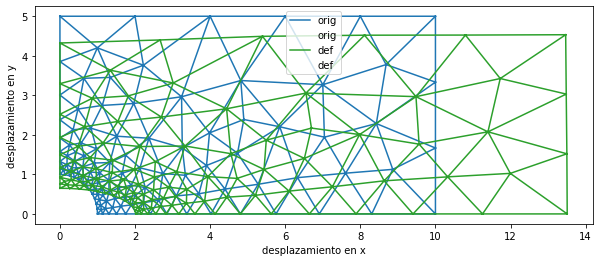

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
plt.triplot(MN[:,0], MN[:,1], MC, label='orig')  # triplot = grafica triangulitos
plt.triplot(MNdef[:,0], MNdef[:,1], MC, label='def')
plt.legend()
plt.ylabel('desplazamiento en y')
plt.xlabel('desplazamiento en x')

In [29]:
desps = gmsh.view.add("Desplazamientos")
Desps = gmsh.view.addModelData(desps, 0, 'Chapa_agujero_central', 'NodeData', NodeInfo[0]+1, U3D, numComponents=3)
gmsh.option.setNumber(f'View[{desps}].VectorType',5)

F2D = F.reshape(Nn,glxn)
F3D = np.append(F2D,np.zeros(F2D.shape[0]).reshape([-1,1]),1)

fuerzas = gmsh.view.add('Fuerzas')
Fuerzas = gmsh.view.addModelData(fuerzas, 0, 'Chapa_agujero_central','NodeData',NodeInfo[0]+1, F3D, numComponents=3)
gmsh.option.setNumber(f'View[{fuerzas}].VectorType',4)
gmsh.option.setNumber(f'View[{fuerzas}].GlyphLocation',2)

sig_xytau = np.hstack(list(sig.values()))  # saco las tensiones del diccionario, quedan en filas para cada elemento las tensiones x, y, xy

sigx = gmsh.view.add('Tensiones en x')
sigy = gmsh.view.add('Tensiones en y')
sigxy = gmsh.view.add('Tensiones xy')
SIGX = gmsh.view.addModelData(sigx, 0, 'Chapa_agujero_central', 'ElementData', ETAGS, sig_xytau[0,:].reshape([-1,1]), numComponents=1) # hago reshape porque tienen que ir vectores columnas
SIGY = gmsh.view.addModelData(sigy, 0, 'Chapa_agujero_central', 'ElementData', ETAGS, sig_xytau[1,:].reshape([-1,1]), numComponents=1)

# gmsh.fltk.run() estoy en remoto

$$
$$

$$ \Large
\textbf{Se muestran los resultados obtenidos:}
$$

<center><img src="ImgProb02_desplazamientos.png"></center>

<center><img src="ImgProb02_tensionesenx.png"></center>

<center><img src="ImgProb02_tensioneseny.png"></center>

Se observa que la mayor concentración de tensiones ocurre en la parte superior del agujero y por simetria también ocurrirá en la parte inferior.

Primero debo ubicar en que elementos hay mayor concentración de tensiones. Las tensiones en la dirección x son 1 orden de magnitud alcanzan máximos del doble de magnitud en comparacion a las tensiones en y. Por eso, analizaré los elementos con mayor concentración de tensiones en x.

<center><img src="ETAGS_Imagen.png"></center>

<center><img src="TensionesPorElementoColores.png"></center>

$$
$$

$ \Large \underline
{\text{Estudio de propagación de fisuras}}
$

Se obtiene facilmente el TAG del elemento más tensionados en la dirección x. Se ve como coincide con las imagenes. 

El inicio de la fisura comienza con un if, que determina si hay o no un elemento que alcance la tension a la rotura del material. 

Lo que pense es: hacer un programa que detecte primero cual es el elemento con máxima tension aplicada. Luego tambien seleccionar algunos elementos alrededor de ese elemento ya que también tendrán una alta tensión aplicada y hay una probabilidad de que la fisura comience por alguno de ellos. Hacer un pequeño programa de aleatoriedad que seleccione uno de estos elementos y luego le de inicio a la fisura. Encontre un comando que se llama plugin(crack) de gmsh pero no pude aprender a usarlo, no lo comprendo, supuestamente es para iniciar agregar una fisura en el modelo. 

Una vez iniciada la fisura usar el mismo programa que selecciona un elemento para propagar la fisura pero con los que rodean la punta de la fisura

Obviamente la fisura debería ir con mayor probabilidad hacia los elementos con mayor tensión para que la dirección en la que se propague sea coherente 

Lo que no me agrada es que de esta manera los puede llegar a ser muy impresisa la propagación de la fisura. Sería puramente para ver como queda la fisura en un dibujo pero creo que estaría muy lejos de la realidad. 

No pude encontrar mucha información. Encontre que se utiliza mucho el método de elementos finitos 'extendido' en abaqus para el estudio de propagación de fisuras pero supera mi conocimiento y no creo llegar en 1 semana a hacerlo. 

Máxima tensión en x medida:

<div style='background:#999900'>Me parece que el problema de las roturas aleatorias es un poco más complicado.
    
    <ol>
        <li>    Acordate qe tiene que ver con las impurezas, los bordes de grano y el endurecimiento local, todo lo cual sobrepasa el scope de lo que se puede hacer en 15 días.
            <li> siempre hay una fisura preexistente. en el paper que mandaste hay fisuras preexistentes, y le dan un tratamiento matemático interesante, pero me da la impresión de que preestablecen el camino de la fisura 
                
</div>

<div style='background:#999900'>Lo que yo propuse en la charla rápida que tuvimos en clase es algo así.
    
<ol>
    <li> variar la tensión remota (incremento)
        
    <li> medir el criterio de propagacion de fisura que no es sobre la tensión de corte o la tensión máxima sino sobre el , 
        <a url="https://en.wikipedia.org/wiki/Stress_intensity_factor#G%E2%80%93criterion">factor de intensidad de tensiones</a>. 
        
    <li> cuando encontrás el elemento que sobrepasa el criterio lo sacás del mallado, simulando una rotura
     
    <li> loop
<ol> 
    
</div>

```
sig_xytau[0,:].max()
max_sig_element = np.where(sig_xytau[0,:] == sig_xytau[0,:].max())
Nro del elemento con mayor tensión aplicada:
ETAGS[max_sig_element]
max_sig_element
```

In [74]:
Gmax  = E

In [77]:
R =1 

In [ ]:
KI = 

<div style='background:#999900'> aver yo empezaría por romper el nodo con la tensión más alta solamente. si sale eso, podes ver de agregar dificultades. </div>

In [38]:
MCbroken1 = np.delete(MC, max_sig_element, axis=0)
ETAGSbroken1 = np.delete(ETAGS, max_sig_element)

(-0.2, 0.3305261925253096)

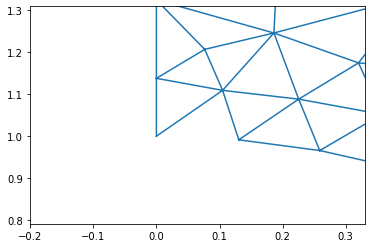

In [71]:
plt.triplot(MN[:,0], MN[:,1], MCbroken1)
coords=MN[MC[max_sig_element].ravel().astype(int),:]
maxes = coords.max(axis=0)
mins = coords.min(axis=0)
plt.ylim(mins[1]-lc/10, maxes[1]+lc/10)
plt.xlim(mins[0]-lc/10, maxes[0]+lc/10)

<div style='background:#999900'>y ahora calculás todo de nuevo con la malla nueva. Basicamente haces un loop con todo hasta que te quedas con fuerza cero! y vas escribiendo archivos nuevos. El problema que tiene esto es que es dificil visualizar , pero se me ocurre:

<ol>
    <li> definir una función que vale 0 para todos los elementos
    <li> cuando hay un elemento que sobrepasa vm, le asignas 1
    <li> guardar los valores escalares de esa función para cada paso de incremento
    
</ol>
</div>

<div style='background:#999900'>y ahora calculás todo de nuevo con la malla nueva. Basicamente haces un loop con todo hasta que te quedas con fuerza cero! y vas escribiendo archivos nuevos. El problema que tiene esto es que es dificil visualizar , pero se me ocurre:

<ol>
    <li> definir una función que vale 0 para todos los elementos
    <li> cuando hay un elemento que sobrepasa vm, le asignas 1
    <li> guardar los valores escalares de esa función para cada paso de incremento
    
</ol>
    
Es cierto que puede sonar medio naive, pero me parece que para no estar peliando en la implementación de esos modelos de fisura mas complejos está muy bien. Si te sale eso, entonces podés empezar a pensar en cosas más complejas, o incluso modelar otro tipo de  fenómeno o dinámica. 
    
Un par de cosas mas: yo aplicaría una malla más fina por donde sabés que va a pasar la fisura, por más que después pueda pasar que por cuestiones numéricas la fisura se te valla para otro lado. 
</div>